# FCAL Simulation $\alpha$ fitting with LSTM Model

This notebook uses the FCAL simulation data Mike produced with a uniform sawtooth $\alpha$.

This fits an LSTM model using the 50 "A" values as inputs with a 200 time step history to predict the value of $\alpha$ of the current time step.

This is based on the keras Timeseries example for weather forecasting found here: 
https://keras.io/examples/timeseries/timeseries_weather_forecasting


This first cell just reads the data, renames the "b*" columns to "A*", and calculates the true $\alpha$, adding it to the dataframe.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

filename = '/work/epsci/davidl/2023.08.18.AIEC_LSTM_simulation/fcal2.csv'

df = pd.read_csv(filename)

# Rename columns from "bX" to "AX" to better align with what we say vocally
name_map = {}
for i in range(1,51):
    name_map['b'+str(i)] = 'A'+str(i)
df = df.rename(columns=name_map)

# Calculate alpha (should work for any pair)
df['alpha'] = df['A17']/df['g17']


df['Aalpha_est'] = df.filter(like="A").mean(axis=1)

2023-08-25 18:52:58.542015: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 18:52:58.621526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 18:52:58.622953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 18:53:00.591049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prepare training and validation sets

This will split the data into training and validation sets. Note that the normalization function (copied from the original keras example) is not used since it seemed to result in much worse model fits. This is not such an issue for this data set since the values are already in a small range around 1.

In [2]:
split_fraction = 0.80
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200   # number of timesteps in the past to use for predicting value(s) for current timestep
future = 0   # number of timesteps in the future to predict value for
learning_rate = 0.002
batch_size = 50
epochs = 100

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


# Create nomalized training and validation sets
# df_norm  = normalize(df, train_split)  # This gives really bad model fits! Do not use!
df_norm  = df
df_train = df_norm[:train_split-1]
df_valid = df_norm[train_split:]
df_train_labels = df[:train_split-1]  # unormalized!
df_valid_labels = df[train_split:]    # unormalized!

# Chop off ends so we have a full set of past elements and corresponding future
x_train = df_train.filter(like="A").values
y_train = df_train_labels.filter(items=["alpha"])[past+future-1:].values
x_valid = df_valid.filter(like="A").values
y_valid = df_valid_labels.filter(items=["alpha"])[past+future-1:].values
print("x_train shape: "+str(x_train.shape) + "   y_train shape: "+str(y_train.shape))
print("x_valid shape: "+str(x_valid.shape) + "   y_valid shape: "+str(y_valid.shape))


x_train shape: (2399, 51)   y_train shape: (2200, 1)
x_valid shape: (600, 51)   y_valid shape: (401, 1)


### Create Timeseries datasets

This creates datasets in a form that can be easily used for training. Note that we use overlapping points. E.g. time steps 0-199 are used to predict $\alpha_{199}$, time steps 1-200 are used to predict $\alpha_{200}$, etc...

The labels ("y"s defined in the cell above) start with the first predicted value. E.g. y_train[0] = $\alpha_{199}$, y_train[1] = $\alpha_{200}$, ...

In [3]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in  dataset_train.take(1): train_inputs, train_targets = batch
print("  Training: Input shape:", train_inputs.numpy().shape, " Target shape:" , train_targets.numpy().shape)

dataset_valid = keras.preprocessing.timeseries_dataset_from_array(
    x_valid,
    y_valid,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in  dataset_valid.take(1): valid_inputs, valid_targets = batch
print("Validation: Input shape:", valid_inputs.numpy().shape, " Target shape:" , valid_targets.numpy().shape)



2023-08-25 18:53:03.373623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-08-25 18:53:03.374262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-08-25 18:53:03.514094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-08-25 18:53

  Training: Input shape: (50, 200, 51)  Target shape: (50, 1)
Validation: Input shape: (50, 200, 51)  Target shape: (50, 1)


## Create Model

In [4]:
inputs = keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))
lstm_out = keras.layers.LSTM(500)(inputs)
residual = keras.layers.Dense(1)(lstm_out)

last_alpha_est = keras.layers.Lambda(lambda x: x[:, -1, -1])(inputs)
last_alpha_est = keras.layers.Reshape((1,))(last_alpha_est)

outputs = keras.layers.Add()([last_alpha_est, residual])
# combined = keras.layers.Concatenate()([lstm_out, reshaped_last_alpha_est])
# outputs = keras.layers.Dense(1)(combined)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 51)]    0           []                               
                                                                                                  
 lambda (Lambda)                (None,)              0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 500)          1104000     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1)            0           ['lambda[0][0]']                 
                                                                                              

2023-08-25 18:53:04.066756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-25 18:53:04.069201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-25 18:53:04.070805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Fit Model

Use early stopping and save the best model to a _.h5_ file.

In [5]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_valid,
    callbacks=[es_callback, modelckpt_callback],
)


2023-08-25 18:53:04.207026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [2200,1]
	 [[{{node Placeholder/_20}}]]
2023-08-25 18:53:04.207758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2200]
	 [[{{node Placeholder/_8}}]]


Epoch 1/100


2023-08-25 18:53:04.646537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-25 18:53:04.648893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-25 18:53:04.650265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - ETA: 0s - loss: 1.0059

2023-08-25 18:53:37.764823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-08-25 18:53:37.765981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [401,1]
	 [[{{node Placeholder/_20}}]]
2023-08-25 18:53:38.185698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype in


Epoch 1: val_loss improved from inf to 0.00018, saving model to model_checkpoint.h5
44/44 [==============================] - 36s 771ms/step - loss: 1.0059 - val_loss: 1.7907e-04
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 5.3411e-04
Epoch 2: val_loss improved from 0.00018 to 0.00013, saving model to model_checkpoint.h5
44/44 [==============================] - 33s 751ms/step - loss: 5.3411e-04 - val_loss: 1.3344e-04
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 1.4004e-04
Epoch 3: val_loss improved from 0.00013 to 0.00010, saving model to model_checkpoint.h5
44/44 [==============================] - 33s 746ms/step - loss: 1.4004e-04 - val_loss: 1.0129e-04
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 1.2922e-04
Epoch 4: val_loss improved from 0.00010 to 0.00009, saving model to model_checkpoint.h5
44/44 [==============================] - 33s 744ms/step - loss: 1.2922e-04 - val_loss: 9.4891e-05
Epoch 5/100
44/44 [====

### Loss Function

n.b. This is plotted on a log scale

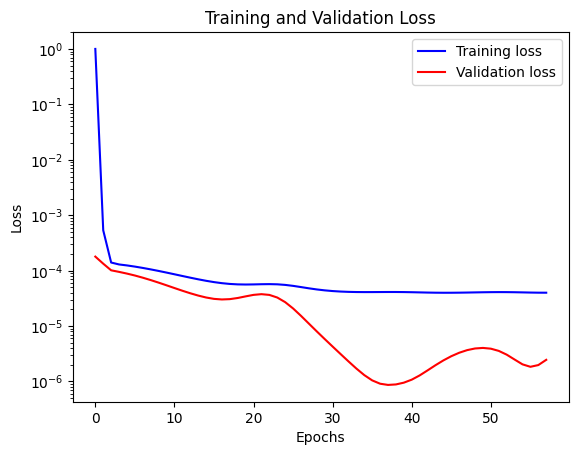

In [6]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

### Example predictions

Plot a few examples showing the $\alpha$ truth history and the model prediction. This is also carried over from the keras weather example. The red "X" is just the last point in the truth history since here, we are not trying to predict the future, only use the past to predict the present.

n.b. Unlike the original example for the weather which included Temperature in the features and was used to predict Temperature in the future, this problem does not directly measure $\alpha$. Thus these blue points are useful to guide the human eye, but are not values the model sees.

The first 3 plots are from the validation set while the second three are from the training set.

1/1 [==============================] - 0s 407ms/step


2023-08-25 19:26:54.166829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-25 19:26:54.168366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-25 19:26:54.169494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

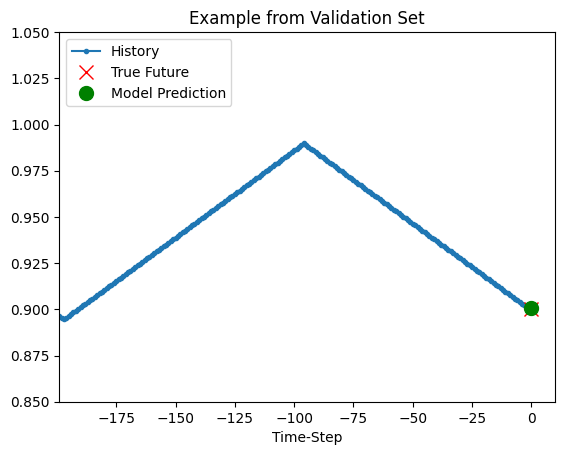

1/1 [==============================] - 0s 77ms/step


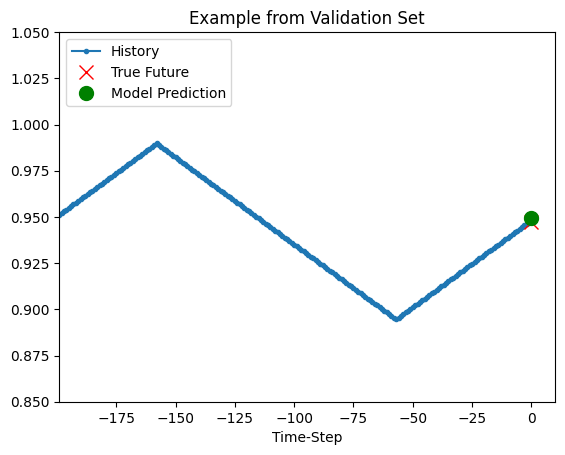

1/1 [==============================] - 0s 70ms/step


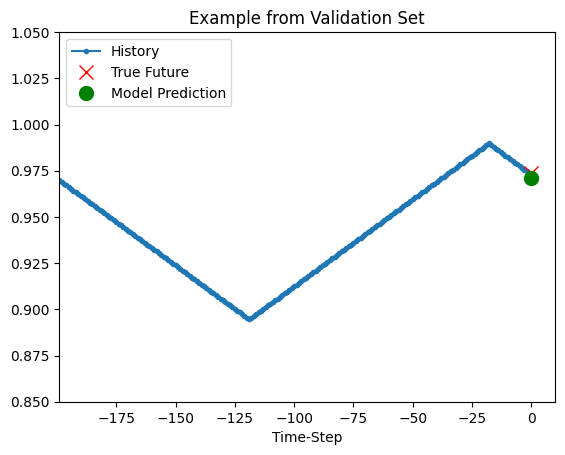

1/1 [==============================] - 0s 82ms/step


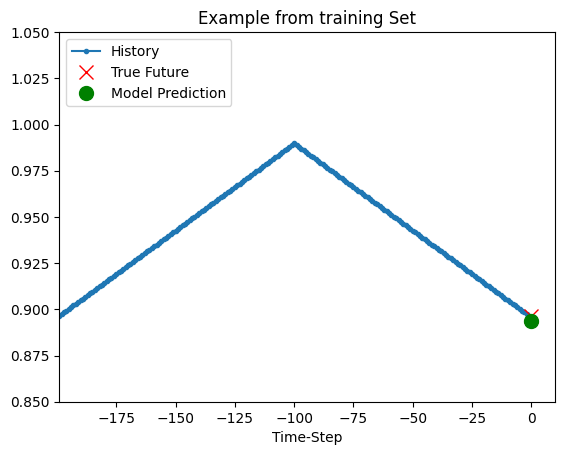

1/1 [==============================] - 0s 80ms/step


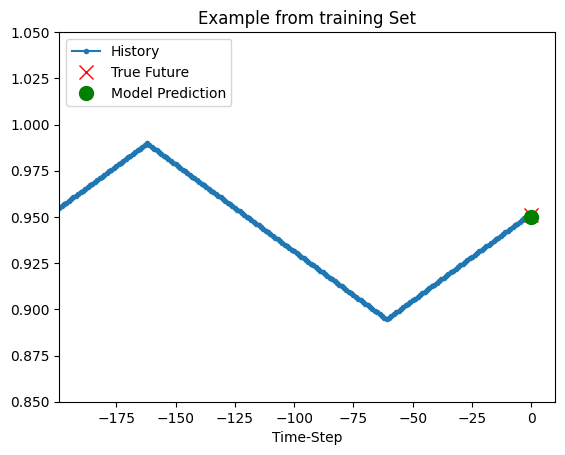

1/1 [==============================] - 0s 75ms/step


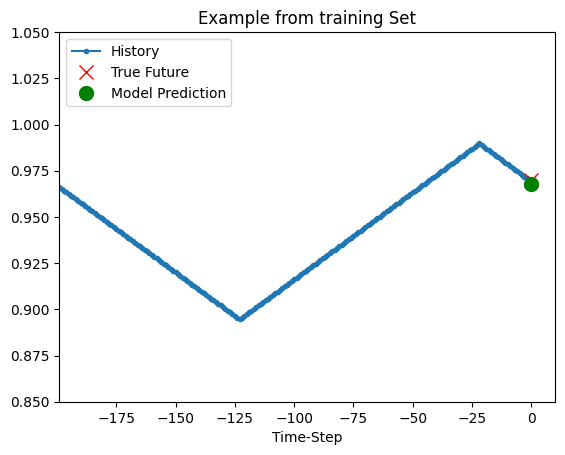

In [7]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future_ = delta
    else:
        future_ = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future_, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend(loc="upper left")
    plt.xlim([time_steps[0], (future_ + 5) * 2])
    plt.ylim([0.85, 1.050])
    plt.xlabel("Time-Step")
    plt.show()
    return

# This has the alpha history with last point being the same as the label
alpha_valid = df_valid_labels.filter(items=["alpha"])[:-(past+future)].values
alpha_train = df_train_labels.filter(items=["alpha"])[:-(past+future)].values

 
# Validation examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_valid[start:start+past], 0)
    y_history = alpha_valid[start:start+past-1]
    y_true = y_history[-1]
    # print("shape x: ", x.shape, '  y_history:',y_history.shape, ' y_true:',y_true.shape)
    y_pred = model.predict(x)
    # print('shape y_pred:',y_pred.shape)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from Validation Set")

# Training examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_train[start:start+past], 0)
    y_history = alpha_train[start:start+past-1]
    y_true = y_history[-1]
    # print("shape x: ", x.shape, '  y_history:',y_history.shape, ' y_true:',y_true.shape)
    y_pred = model.predict(x)
    # print('shape y_pred:',y_pred.shape)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from training Set")


## Results

The following cell performs inference on the entire dataset (training and validation). The results are stored in the original dataframe as column "alpha_model".

In [8]:
# Create overlapping windows of data
x_all = df_norm.filter(like="A").values
num_windows = x_all.shape[0] - past +1
windows = np.lib.stride_tricks.sliding_window_view(x_all, (past, x_all.shape[1]))

df['alpha_model'] = np.nan

# Predict using batches and update df
batch_size = 32
for i in range(0, num_windows, batch_size):
    batch_windows = windows[i:i+batch_size]
     # Reshape batch_windows to match the model's input shape
    batch_windows_reshaped = np.reshape(batch_windows, (batch_windows.shape[0], past, batch_windows.shape[-1]))
    y_pred_batch = model.predict(batch_windows_reshaped, verbose=0)
    y_pred_batch_flattened = y_pred_batch.flatten()
    this_batch_size = batch_windows.shape[0]
    df.loc[i+past-1:i+this_batch_size+past-1-1, 'alpha_model'] = y_pred_batch
    print("\rprocessed: {}/{}".format(i, num_windows), end="")


processed: 2784/2801

# $\alpha$ Model vs Truth

The top plot below shows the true $\alpha$ and the one predicted by the model. Since the model requires 200 past timesteps, its predictions are only available for timestep 200 and later.

The bottom plot shows the error (residual) bewtween $\alpha$ and the model prediction. It shows values within $\pm1.25$%.

<Axes: >

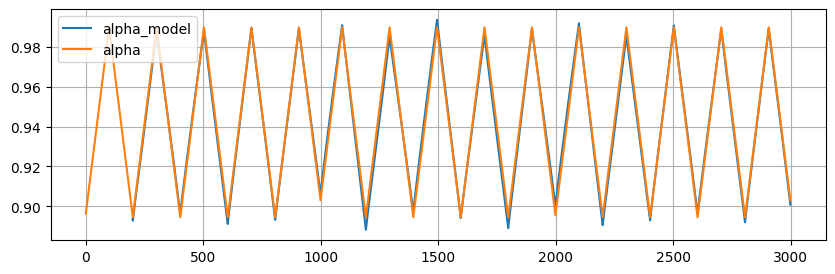

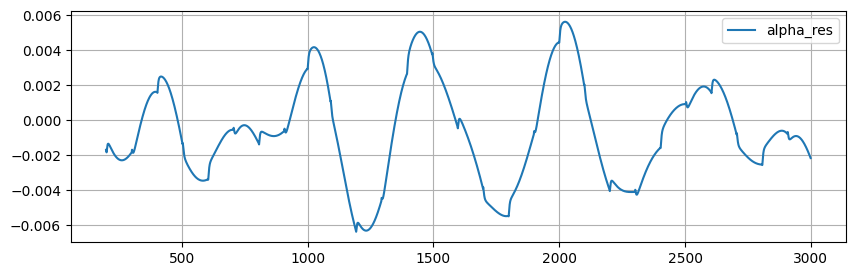

In [9]:
df.plot(y=["alpha_model", "alpha"], kind="line", grid=True, figsize=(10,3))

df["alpha_res"] = df["alpha_model"] - df["alpha"]
df.plot(y=["alpha_res"], kind="line", grid=True, figsize=(10,3))